### Data Visualization

In [43]:
import pandas as pd

df = pd.read_csv('training.csv')

In [44]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   subtotal                                      197428 non-null  int64  
 5   total_onshift_dashers                         181166 non-null  float64
 6   total_busy_dashers                            181166 non-null  float64
 7   total_outstanding_orders                      181166 non-null  float64
 8   estimated_store_to_consumer_driving_duration  196902 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 

In [45]:
print(df.describe())

           market_id       store_id       subtotal  total_onshift_dashers  \
count  196441.000000  197428.000000  197428.000000          181166.000000   
mean        2.978706    3530.510272    2682.331402              44.808093   
std         1.524867    2053.496711    1823.093688              34.526783   
min         1.000000       1.000000       0.000000              -4.000000   
25%         2.000000    1686.000000    1400.000000              17.000000   
50%         3.000000    3592.000000    2200.000000              37.000000   
75%         4.000000    5299.000000    3395.000000              65.000000   
max         6.000000    6987.000000   27100.000000             171.000000   

       total_busy_dashers  total_outstanding_orders  \
count       181166.000000             181166.000000   
mean            41.739747                 58.050065   
std             32.145733                 52.661830   
min             -5.000000                 -6.000000   
25%             15.000000      

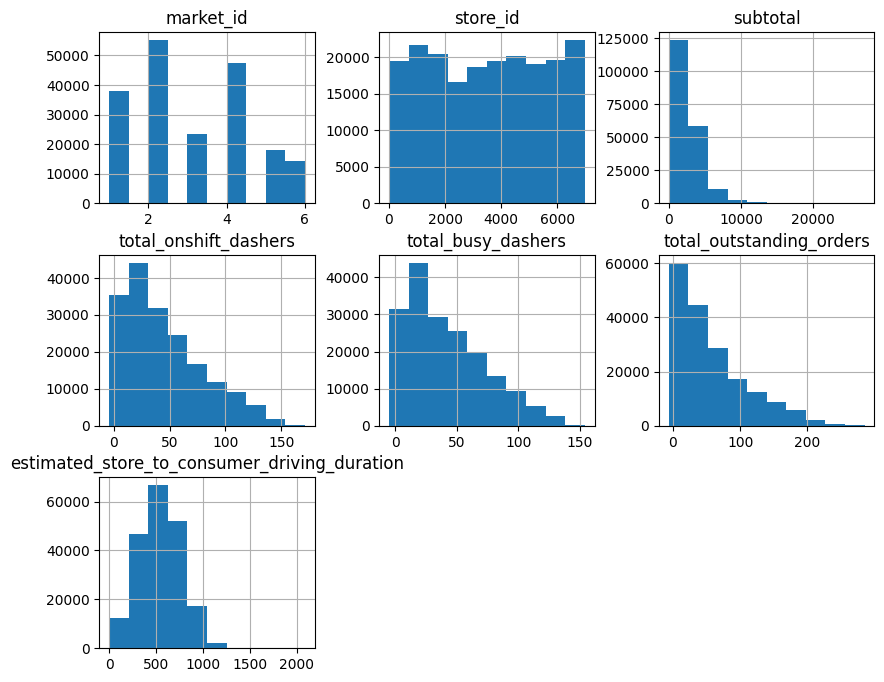

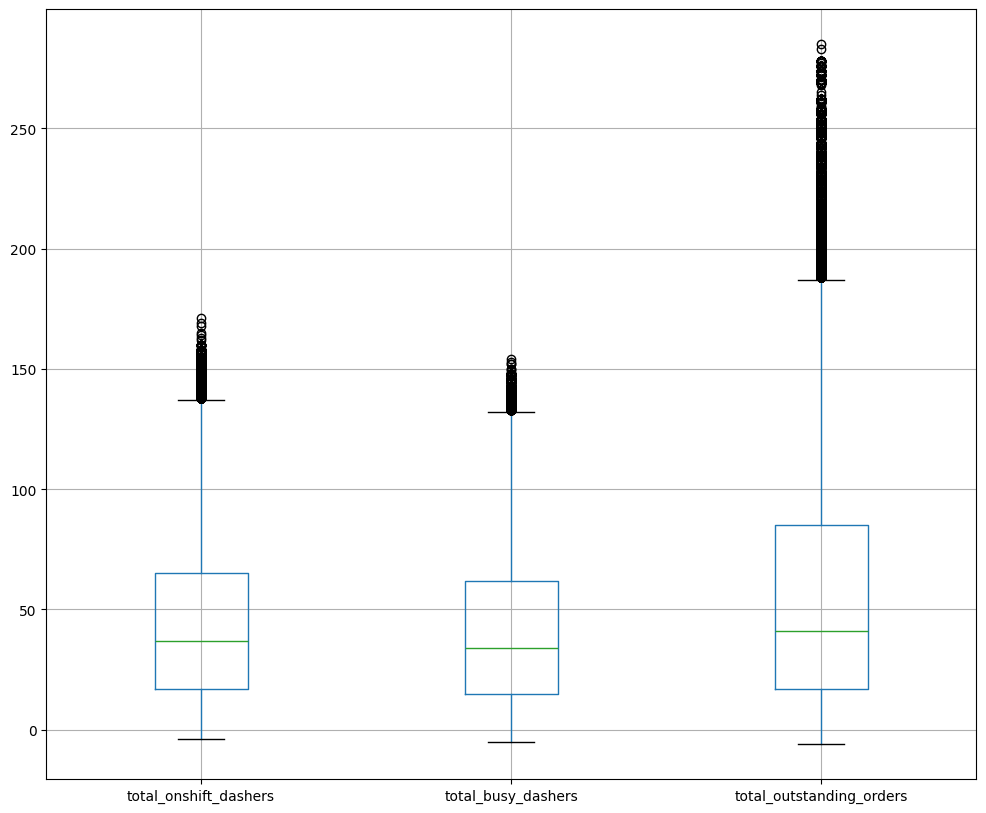

In [46]:
import matplotlib.pyplot as plt

df.hist(figsize=(10, 8))
plt.show()

# Removing some of the features because they're either irrelavent or throw off the visualization of the rest
df.drop(['store_id', 'market_id', 'subtotal', 'estimated_store_to_consumer_driving_duration'], axis=1).boxplot(figsize=(12, 10))
plt.show()

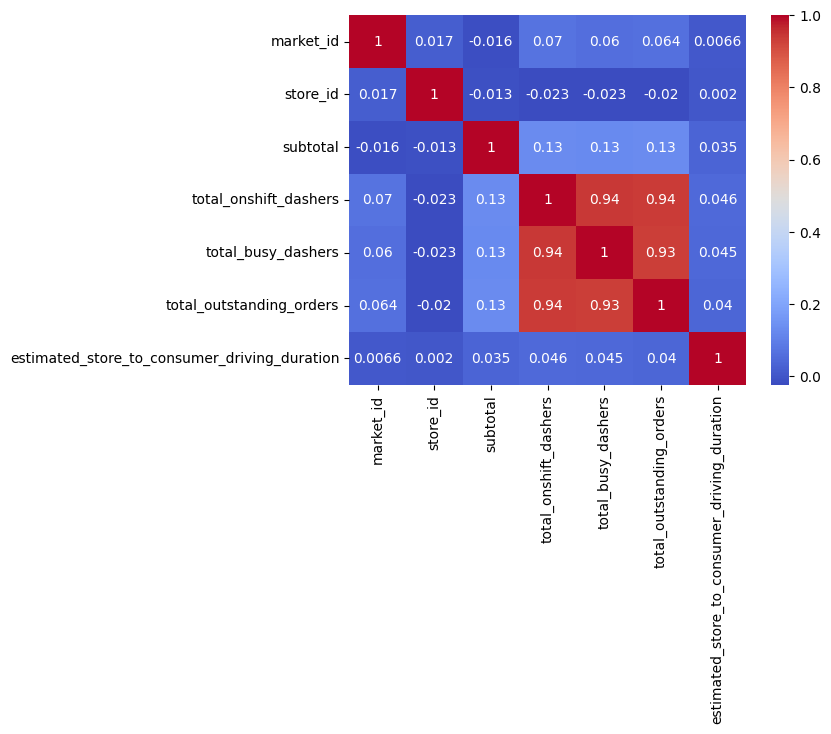

In [47]:
import numpy as np
import seaborn as sns


numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

There doesn't seem to be strong correlation between the features.

### Data Cleaning
1. Dropping irrelevant columns.
2. Dropping duplicates.
3. Null exists? Drop them.

In [48]:
# StoreId seems like an arbitrary number assigned at a database level, so dropping it.
# df = df.drop('store_id', axis=1)

After rethinking about this point, it seems that the store id might convey some information about the how long orders are being prepared. So although, I'd prefer an input on how long a certain order takes, the next best thing is probably how long all orders from a certain store takes.

So, I modified the code to take store id into account.

In [49]:
observation_count = df.shape[0]
print(f'Number of observations: {observation_count}')

df.drop_duplicates(inplace=True)

observation_count = df.shape[0]
print(f'Number of observations: {observation_count}')

Number of observations: 197428
Number of observations: 197428


In [50]:
# Print all rows with NAN/Nulls before.
print(df[df.isnull().any(axis=1)])

df = df.dropna(axis = 0, how='any')

observation_count = df.shape[0]
print(f'Number of observations: {observation_count}')

print('------------------------------')

# Print all rows with NAN/Nulls after.
print(df[df.isnull().any(axis=1)])

print(f'Number of observations: {observation_count}')



        market_id           created_at actual_delivery_time  store_id  \
45            NaN  2015-02-09 03:27:37  2015-02-09 04:22:18      5054   
92            3.0  2015-01-29 18:56:20  2015-01-29 19:26:39      1698   
109           3.0  2015-02-10 21:51:54                  NaN      1698   
160           6.0  2015-02-06 01:11:56  2015-02-06 01:42:51       976   
161           6.0  2015-02-14 02:07:47  2015-02-14 03:17:37       976   
...           ...                  ...                  ...       ...   
197199        3.0  2015-01-24 03:15:41  2015-01-24 04:04:19      5382   
197209        1.0  2015-01-29 20:15:51  2015-01-29 21:03:01      2177   
197259        NaN  2015-02-10 01:32:37  2015-02-10 02:02:09      1340   
197416        1.0  2015-01-29 19:39:17  2015-01-29 20:34:21      2956   
197421        1.0  2015-01-30 03:35:01  2015-01-30 04:42:19      2956   

        subtotal  total_onshift_dashers  total_busy_dashers  \
45          2400                   94.0                92.0 

### Data Transformation
The operations here:
1. Create the unobserved column.
2. Transform categorical columns to one-hot encoding representation.
3. Drop the unused columns.

#### 1. Create the unobserved column
The unobserved or the regressed on variable is: "delivery time." This is not directly provided but easily deduced by subtracting the actual_delivery_time from created_at. We will create a new column for it. It makes sense that the newly created column to be in the same units as `estimated_store_to_consumer_driving_duration` which is seconds. 

In [51]:
df['delivery_time'] = (pd.to_datetime(df['actual_delivery_time']) - pd.to_datetime(df['created_at'])).dt.seconds

Now, let's inspect that the operation worked as expected

In [52]:
print(pd.to_datetime(df['actual_delivery_time'][0]))
print(pd.to_datetime(df['created_at'][0]))
print(df['delivery_time'][0])

# 1 hour 3 minutes and -1 seconds
# = 60 * 60 + 3 * 60 - 1
# = 3600 + 180 - 1
# = 3779

print(pd.to_datetime(df['actual_delivery_time'][1]))
print(pd.to_datetime(df['created_at'][1]))
print(df['delivery_time'][1])

# 1 hour 7 minutes and 4 seconds
# = 60 * 60 + 7 * 60 + 4
# = 3600 + 420 + 4
# = 3779

# It seems like it's working as expected


2015-02-06 23:27:16
2015-02-06 22:24:17
3779
2015-02-10 22:56:29
2015-02-10 21:49:25
4024


Now, let's visualize it.

count    179759.000000
mean       2863.376966
std        1177.657511
min         101.000000
25%        2105.000000
50%        2662.000000
75%        3383.000000
max       73282.000000
Name: delivery_time, dtype: float64


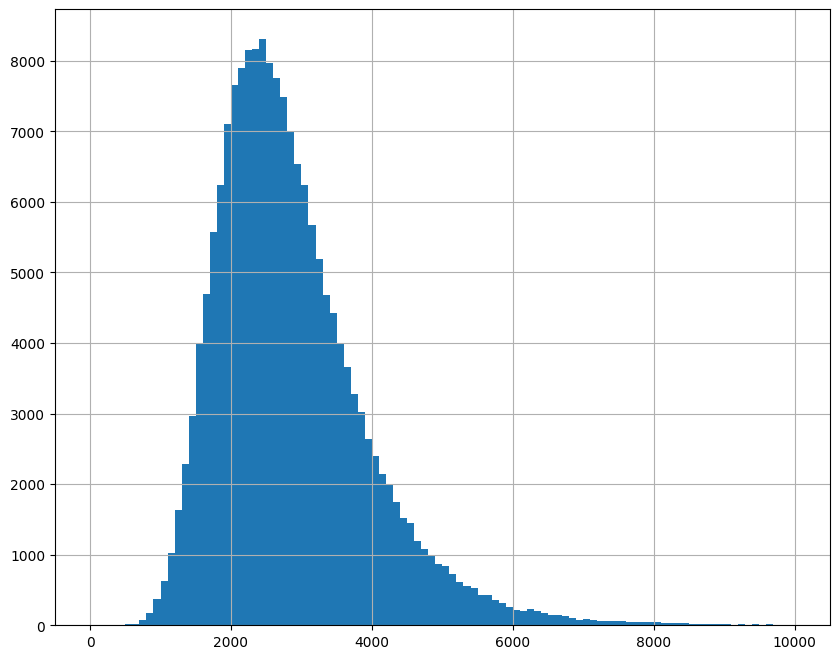

In [53]:
print(df['delivery_time'].describe())

df['delivery_time'].hist(figsize=(10, 8), bins=100, range=(0, 10000))
plt.show()

Now, let's see if how it compares to the other features:

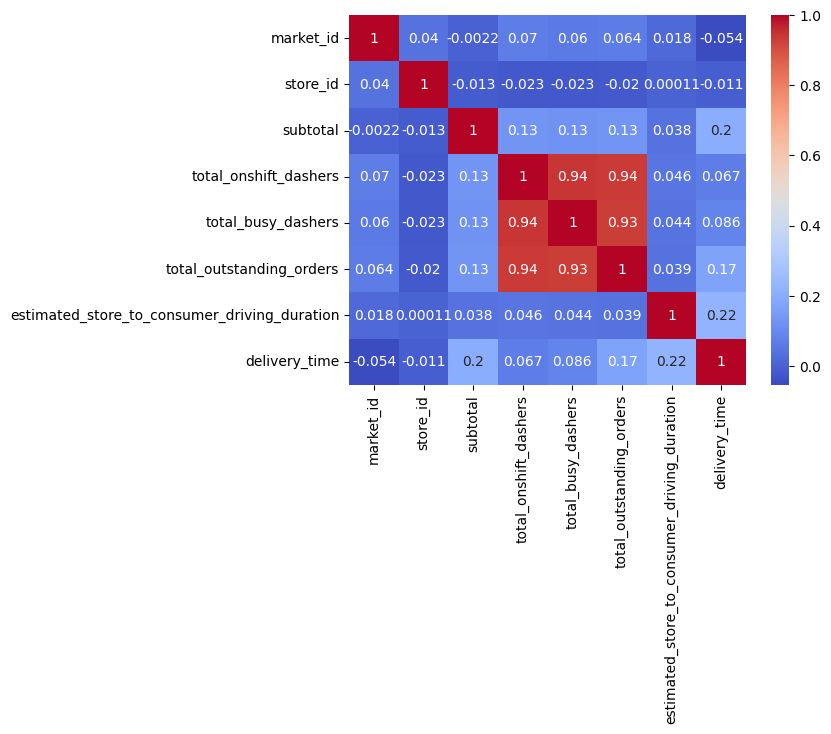

In [54]:
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

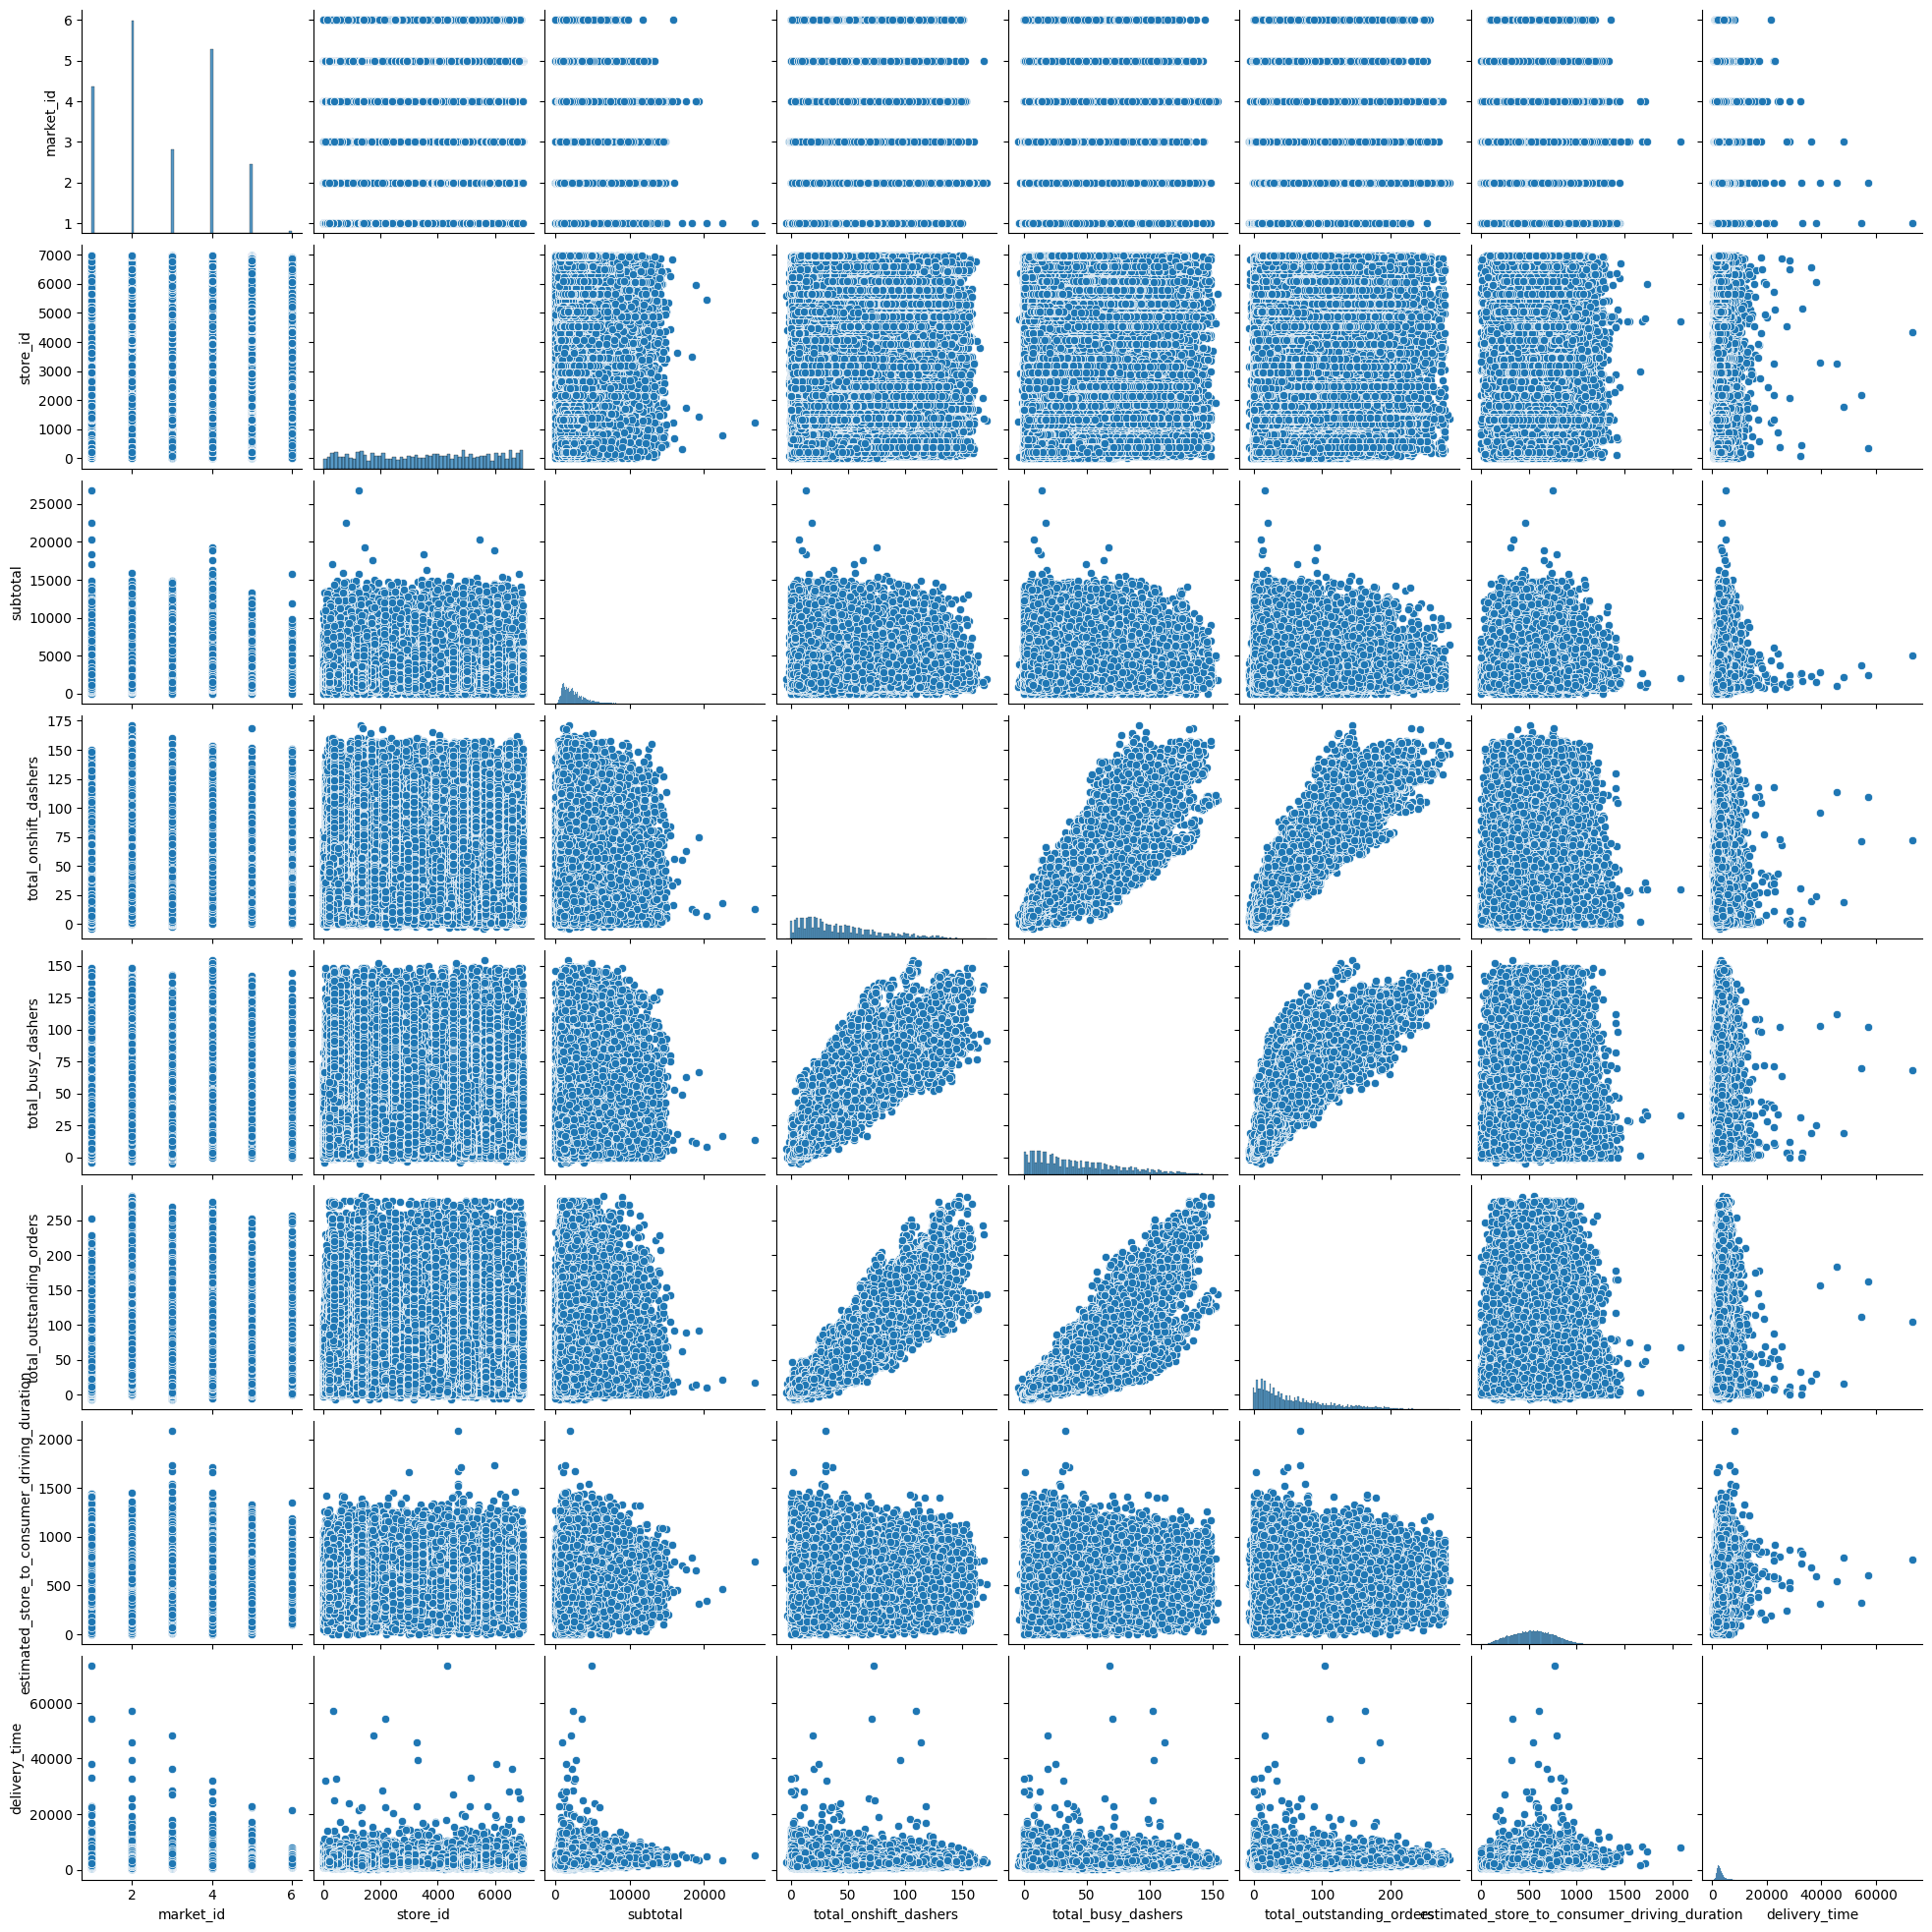

In [55]:
sns.pairplot(df)
plt.show()

2. Transform categorical columns to one-hot encoding representation.

In [56]:
df_encoded = pd.get_dummies(df, columns=['market_id'])
print(f'headers: {df_encoded.columns.values.tolist()}')
print(df_encoded['market_id_1.0'].describe())

headers: ['created_at', 'actual_delivery_time', 'store_id', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration', 'delivery_time', 'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0']
count     179759
unique         2
top        False
freq      142018
Name: market_id_1.0, dtype: object


Let's confirm that encoding works as expected

In [57]:
print(df['market_id'][0])
print(df_encoded['market_id_1.0'][0])
print(df_encoded['market_id_2.0'][0])
print(df_encoded['market_id_3.0'][0])
print(df_encoded['market_id_4.0'][0])
print(df_encoded['market_id_5.0'][0])
print(df_encoded['market_id_6.0'][0])

print('\n')

print(df['market_id'][1])
print(df_encoded['market_id_1.0'][1])
print(df_encoded['market_id_2.0'][1])
print(df_encoded['market_id_3.0'][1])
print(df_encoded['market_id_4.0'][1])
print(df_encoded['market_id_5.0'][1])
print(df_encoded['market_id_6.0'][1])

1.0
True
False
False
False
False
False


2.0
False
True
False
False
False
False


3. Drop the unused columns for regression

In [58]:
print(f'headers: {df_encoded.columns.values.tolist()}')
df_encoded = df_encoded.drop(['created_at', 'actual_delivery_time'], axis = 1)
print(f'headers: {df_encoded.columns.values.tolist()}')

headers: ['created_at', 'actual_delivery_time', 'store_id', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration', 'delivery_time', 'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0']
headers: ['store_id', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration', 'delivery_time', 'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0']


### Regression

We can start with a linear model and then test how sane it is and then regularize it and then work out our custom optimization function to punish overestimating more than underestimating.

In [59]:
from sklearn.model_selection import train_test_split

X = df_encoded[['subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration', 'store_id', 'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0']]
y = df_encoded['delivery_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print('R-squared:', r2_score(y_test, predictions))

Mean Squared Error: 1165619.3540740872


Let's inspect the predicated values in more details.

In [61]:
y_test_list = y_test.tolist()
print(round(y_pred[0]))
print(y_test_list[0])

print('\n')

print(round(y_pred[1]))
print(y_test_list[1])

3025
2447


2515
3143


Let's plot the residuals to see that this regression makes sense.

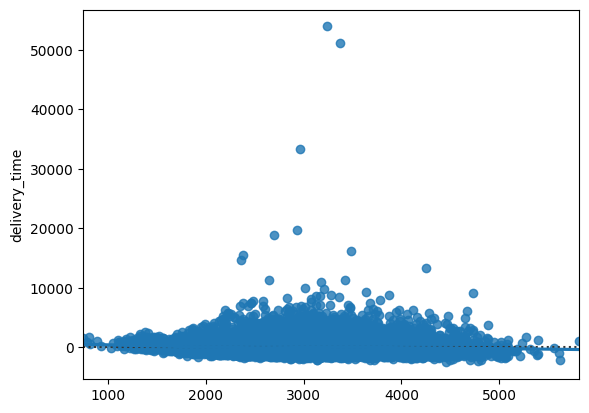

In [62]:
sns.residplot( x= y_pred, y = y_test, lowess = True, robust = True)
plt.show()

In [63]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=200, random_state=42)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)

print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('R-squared:', r2_score(y_test, predictions))

Mean Squared Error: 1141005.7552066194
R-squared: 0.21535693386507426


In [24]:
from sklearn.preprocessing import PolynomialFeatures

for degree in [2, 3, 4, 5]:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    y_pred = poly_model.predict(X_test_poly)
    
    print('Degree: ', degree)
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R-squared:', r2_score(y_test, y_pred))


Degree:  2
Mean Squared Error: 1119476.36066602
R-squared: 0.23016219673713156
Degree:  3
Mean Squared Error: 1108397.8982244814
R-squared: 0.23778059716896416
Degree:  4
Mean Squared Error: 1109140.1306363957
R-squared: 0.2372701812373954
Degree:  5
Mean Squared Error: 1143798.644848517
R-squared: 0.21343632874805785


In [ ]:
from sklearn.linear_model import Ridge

alpha = 0.5
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R^2 Score: {r2_score(y_test, y_pred)}')

In [65]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression; no activation function
])

model.compile(optimizer=Adam(), loss='mse')

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32)

test_loss = model.evaluate(X_test_scaled, y_test)
y_pred = model(X_test_scaled)

print(f'Test MSE: {test_loss}')
print('R-squared:', r2_score(y_test, y_pred))

Epoch 1/100


/Users/shehab.yasser/projects/ml-exercise/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3596/3596 ━━━━━━━━━━━━━━━━━━━━ 3s 674us/step - loss: 1984013.5000 - val_loss: 1069549.2500
Epoch 2/100
3596/3596 ━━━━━━━━━━━━━━━━━━━━ 2s 571us/step - loss: 1086236.7500 - val_loss: 1002775.6875
Epoch 3/100
3596/3596 ━━━━━━━━━━━━━━━━━━━━ 2s 580us/step - loss: 1093473.7500 - val_loss: 996337.1250
Epoch 4/100
3596/3596 ━━━━━━━━━━━━━━━━━━━━ 2s 592us/step - loss: 991713.0000 - val_loss: 988629.6250
Epoch 5/100
3596/3596 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step - loss: 1005085.8125 - val_loss: 990239.8750
Epoch 6/100
3596/3596 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step - loss: 1120503.0000 - val_loss: 985913.4375
Epoch 7/100
3596/3596 ━━━━━━━━━━━━━━━━━━━━ 2s 579us/step - loss: 1066135.2500 - val_loss: 1016302.1250
Epoch 8/100
3596/3596 ━━━━━━━━━━━━━━━━━━━━ 2s 571us/step - loss: 1001196.0000 - val_loss: 1025921.1250
Epoch 9/100
3596/3596 ━━━━━━━━━━━━━━━━━━━━ 2s 594us/step - loss: 1022029.2500 - val_loss: 1014935.6875
Epoch 10/100
3596/3596 ━━━━━━━━━━━━━━━━━━━━ 2s 594us/step - loss: 1028047.2500 - val_loss:

### Feature Importance

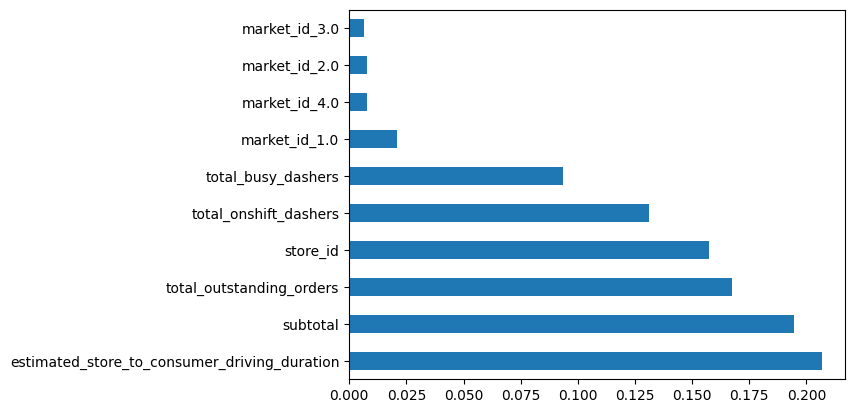

In [66]:
feature_importances = pd.Series(regressor.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

Nothing surprising in the bar chart, as much as why can't we leverage the two biggest contributors (with no colinearity) features: `estimated_store_to_consumer_driving_duration` and `subtotal`.

Explained variance ratio of each component:
[2.86736532e-01 1.17429711e-01 1.02670867e-01 9.39367736e-02
 8.51215549e-02 8.37359085e-02 8.28063258e-02 7.81227367e-02
 5.92239255e-02 5.60394134e-03 4.61172298e-03 1.13286926e-30]


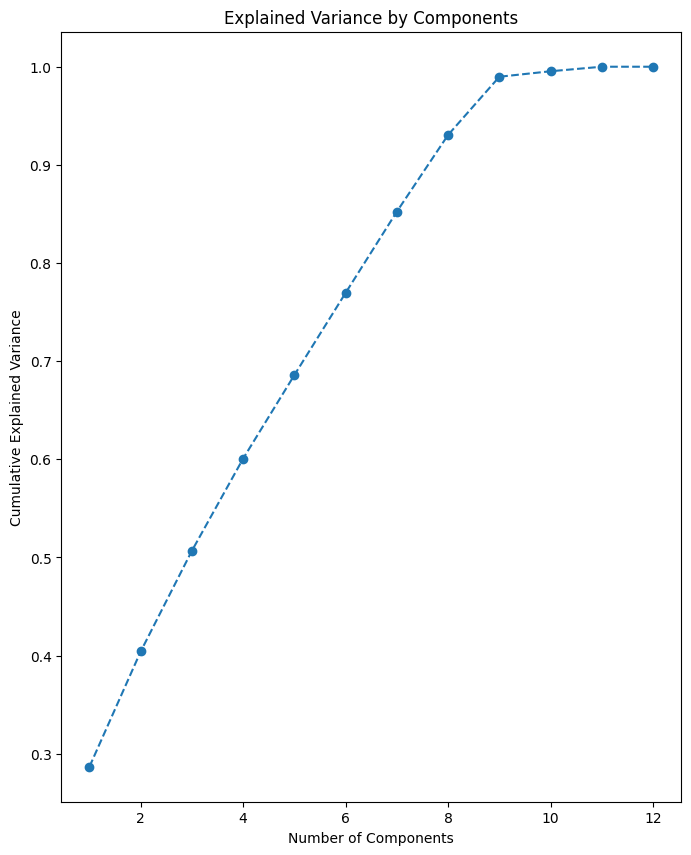

In [68]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded.drop('delivery_time', axis=1))

pca = PCA(n_components=None)
pca.fit(df_scaled)

df_pca = pca.transform(df_scaled)

print("Explained variance ratio of each component:")
print(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 10))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Test Dataset

In [83]:
test_df = pd.read_csv('test.csv')
test_df = pd.get_dummies(df, columns=['market_id'])
X_test_scaled = scaler.transform(test_df.drop(['created_at', 'delivery_id'], axis = 1))
y_pred = model(X_test_scaled)
y_pred_list = y_pred.numpy().tolist()
print(pd.to_datetime(df['created_at']) +  pd.to_timedelta(y_pred_list, unit='s'))

0       2015-02-25 03:00:01.558349609
1       2015-02-25 01:51:50.558349609
2       2015-02-22 03:05:15.558349609
3       2015-02-25 02:10:10.558349609
4       2015-02-24 05:58:16.558349609
                     ...             
54773   2015-02-20 18:48:49.558349609
54774   2015-02-21 21:39:15.558349609
54775   2015-02-21 18:56:50.558349609
54776   2015-02-20 00:20:57.558349609
54777   2015-02-23 03:04:33.558349609
Length: 54778, dtype: datetime64[ns]
